In [1]:
# Final version of the water-filling in 1dspace-time.

In [2]:
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

In [3]:
# parameters


NFREQ = 300 # discretization
f1 = 1e-5 # lowest freq
f2 = 1e1 # highest freq


## equilibrated trapezoid
N = 1 # noise level



In [4]:
# Generate spectrum

X = np.exp(np.linspace(np.log(f1),np.log(f2),NFREQ))
T = np.exp(np.linspace(np.log(f1),np.log(f2),NFREQ))

GX,GT = np.meshgrid(X[:-1],T[:-1])

# Power density
Sdensity = 1/(GX**2*GT**2)
S = np.diff(-1/X)[:,np.newaxis]*np.diff(-1/T)[:,np.newaxis].T

print(S.shape)

# Total Power
total_S = np.sum(S)

print(total_S)

(299, 299)
9999980000.010004


In [5]:
## Compute water filling for a range of lambdas

# range of lambdas
NLAMBDAS = 200
lambdas = np.logspace(8,20,NLAMBDAS)

# library of water-filling solutions for different lamdas
Ws = list()
for lambd in lambdas:
    F = np.sqrt(N/(lambd*Sdensity)) - N/Sdensity #Filter Magnitue Square per mode
    W = S*F #Total water per block
    W[W<0] = 0 
    
    #plt.figure()
    #plt.imshow(np.sqrt(W), cmap = 'seismic', vmin = -np.max(np.sqrt(W)), vmax =  np.max(np.sqrt(W)),origin='lower')
    #plt.colorbar()
    
    Ws.append(W.T)

Ws = np.array(Ws).T
Ws.shape


(299, 299, 200)

In [6]:
# Sum across temporal frequencies (we don't need those)

# volume of each voxel
Nf = np.diff(X)[:,np.newaxis]*np.diff(T)[:,np.newaxis].T

# Precompute variance per mode explained for all lambdas
colVarExpl = np.sum(S[:,:,np.newaxis]*Ws/(Ws+N*Nf[:,:,np.newaxis]),axis =0)
# cumulative variance explained (it's going to fasten up things in the grid search)
cumVarExpl = np.vstack((np.zeros(NLAMBDAS),np.cumsum(colVarExpl,axis = 0)))

# Water filling array for all modes and lamdas
colWs = np.sum(Ws,axis = 0)
# Cumulative Water filling array (it's going to fasten up things in the grid search)
cumWs = np.vstack((np.zeros(NLAMBDAS),np.cumsum(colWs,axis = 0)))

print(colVarExpl.shape, cumVarExpl.shape,colWs.shape, cumWs.shape)

(299, 200) (300, 200) (299, 200) (300, 200)


In [7]:
## Iterate over all possible decompositions between N cell types to find the best one

RECS = list()
STRS = list()

# Number of types
for NTYPES in range(1,3):

    ## Create grid for grid search

    # Create grid for grid search over strides for different types
    STEP = 1 # step of the grid search
    strides = np.arange(0,NFREQ,STEP)
    NSTRIDES = len(strides)
    g = [strides for i in range(NTYPES)]
    g = np.meshgrid(*g)
    stride_grid = np.array([gi.ravel() for gi in g])

    # Create grid for grid serach over lambdas to find best objective
    g = [np.arange(0,NLAMBDAS) for i in range(NTYPES)]
    g = np.meshgrid(*g)
    lambda_grid = np.array([gi.flatten() for gi in g])

    print(stride_grid.shape,lambda_grid.shape)

    recs = list()
    strides = list()

    # Total firing rate threshold ('number of spikes')
    for NSPIKES in np.logspace(-6,-2,20):
        #print(NSPIKES)

        GRID = np.zeros(NTYPES)
        NITER =  stride_grid.shape[1]

        EXPL = np.zeros(NITER)
        OBJ = np.zeros(NITER)
        LAMB = np.zeros((NITER,NTYPES))
        
        # start grid search over strides of each type
        for i in range(NITER):
            lims = stride_grid[:,i] # end limit of the modes covered by each type

            if np.all(np.diff(lims)>0) and lims[0]>0: # if all limits are in an 
                #increasing order (avoid switching types) 


                lims2 = [0,*lims]
                
                #print(lims)

                all_varsExpl = list()
                all_l1s = list()
                for typ in range(NTYPES):

                    # Variance explained for each lambda
                    varExp = cumVarExpl[lims2[typ+1]] - cumVarExpl[lims2[typ]]

                    # Budget of cells for each type
                    budgetCells = X[lims2[typ+1]] - X[lims2[typ]]

                    # penalty
                    l1_penalty = np.sqrt(budgetCells*(cumWs[lims2[typ+1]]- cumWs[lims2[typ]]))

                      
                    all_varsExpl.append(varExp)
                    all_l1s.append(l1_penalty)


                all_varsExpl = np.array(all_varsExpl)
                total_varsExpl = sum([all_varsExpl[ityp,lambda_grid[ityp]] for ityp in range(NTYPES)])
                
                all_l1s = np.array(all_l1s)
                total_l1s = sum([all_l1s[ityp,lambda_grid[ityp]] for ityp in range(NTYPES)])
                
                # objective for each lambda
                objective = total_varsExpl - 1e60 * np.maximum(total_l1s - NSPIKES, 0)   

                best_lambdas_ind = np.argmax(objective)
                
                best_lambdas = lambda_grid[:,best_lambdas_ind]
                

                #if 0 in best_lambdas:
                #    print('warning lambda LOWER bound reached',lims)
                #if NLAMBDAS-1 in best_lambdas:
                #    print('warning lambda UPPER bound reached')

                best_objective = objective[best_lambdas_ind]

                best_varExp = total_varsExpl[best_lambdas_ind]

                EXPL[i] = best_varExp
                LAMB[i,:] = best_lambdas        
                OBJ[i] = best_objective
                
                #print(best_objective)
                #print(best_varExp)
                
                #STRIDES[i,:] = best_strides

                #print(lims,best_lambdas,best_objective)

                #print(sumObjs.shape,lambda_grid.shape)
                
        
        iter_max = np.argmax(OBJ)
        
        rec = (np.sum(S) - EXPL[iter_max])/np.sum(S)*100
        st = stride_grid[:,iter_max]

        recs.append(rec)
        strides.append(st)
        #print(np.argmax(EXPL))
        print('RECONSTRUCTION ERROR: ',rec,'%')
        print('BEST NCELLS:', stride_grid[:,iter_max])
        print('BEST LAMBDAS:', LAMB[iter_max])
        print('OBJ:', OBJ[iter_max])
        print('')
        
    RECS.append(recs)
    STRS.append(strides)

(1, 300) (1, 200)
RECONSTRUCTION ERROR:  30.66502233773426 %
BEST NCELLS: [39]
BEST LAMBDAS: [142.]
OBJ: 6933483899.237978

RECONSTRUCTION ERROR:  24.281175062114528 %
BEST NCELLS: [43]
BEST LAMBDAS: [135.]
OBJ: 7571867350.031135

RECONSTRUCTION ERROR:  18.761198848739383 %
BEST NCELLS: [48]
BEST LAMBDAS: [128.]
OBJ: 8123863867.373959

RECONSTRUCTION ERROR:  14.239982660781775 %
BEST NCELLS: [56]
BEST LAMBDAS: [123.]
OBJ: 8575984581.926934

RECONSTRUCTION ERROR:  10.68771691417325 %
BEST NCELLS: [63]
BEST LAMBDAS: [117.]
OBJ: 8931210446.134993

RECONSTRUCTION ERROR:  7.898381686624971 %
BEST NCELLS: [69]
BEST LAMBDAS: [110.]
OBJ: 9210143411.023054

RECONSTRUCTION ERROR:  5.7169550281455175 %
BEST NCELLS: [79]
BEST LAMBDAS: [105.]
OBJ: 9428285640.585886

RECONSTRUCTION ERROR:  4.115344423695461 %
BEST NCELLS: [84]
BEST LAMBDAS: [97.]
OBJ: 9588446380.708931

RECONSTRUCTION ERROR:  2.934200388390021 %
BEST NCELLS: [91]
BEST LAMBDAS: [90.]
OBJ: 9706560548.010786

RECONSTRUCTION ERROR:  2.0

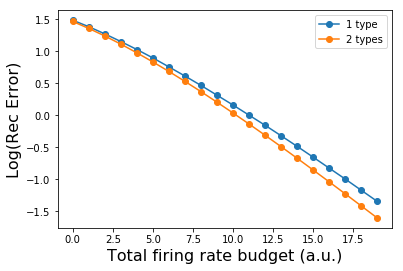

In [8]:
# Reconstruction error wrt spike budgets for different number of types


plt.plot(np.log(np.array(RECS).T)/np.log(10),'-o')
plt.xlabel('Total firing rate budget (a.u.)',fontsize = 16)
plt.ylabel('Log(Rec Error)',fontsize = 16)
#plt.yticks([-1,-2,-3])
plt.legend(['1 type','2 types','3 types'])

#plt.savefig('performance.eps')

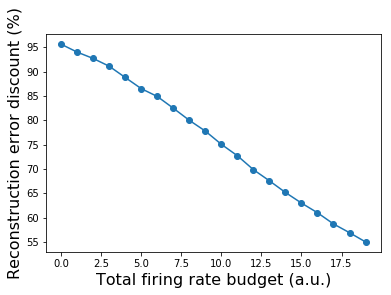

In [9]:
# Ratio of reconstruction error between one type and two types

r = np.array(RECS)
plt.plot(100*r[1]/r[0],'-o')
plt.xlabel('Total firing rate budget (a.u.)',fontsize = 16)
plt.ylabel('Reconstruction error discount (%)',fontsize = 16)
#plt.legend(['1 type','2 types','3 types'])

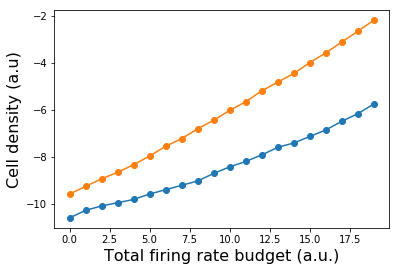

In [10]:
# plot evolution of density with budget

plt.plot(np.log(X[np.array(STRS[1])]),'-o')
#plt.plot(1/np.array(STRS[2]),'-o')
plt.ylabel('Cell density (a.u)',fontsize = 16)
plt.xlabel('Total firing rate budget (a.u.)',fontsize = 16)


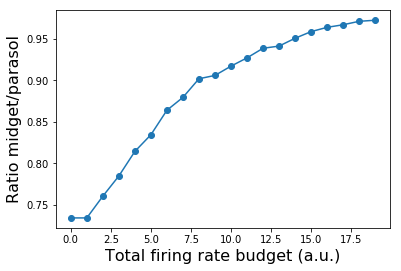

In [11]:
plt.plot(X[np.array(STRS[1])][:,1]/(X[np.array(STRS[1])][:,0]+X[np.array(STRS[1])][:,1]),'-o')
plt.ylabel('Ratio midget/parasol',fontsize = 16)
plt.xlabel('Total firing rate budget (a.u.)',fontsize = 16)

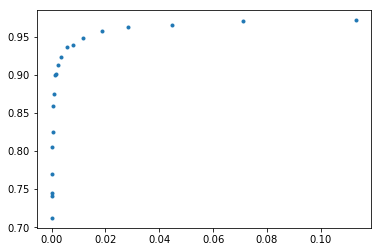

In [12]:
# plot ratio of midget cells against total density of cells


strides = np.array(STRS[1]) # two types
density_midget = X[strides[:,1]]- X[strides[:,0]]
density_parasol = X[strides[:,0]]- X[0]
ratios = density_midget/(density_midget+density_parasol)
total_density = density_midget+density_parasol

plt.plot(total_density, ratios,'.')

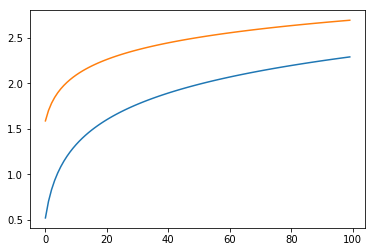

In [13]:
# Dacey 1992 dendritic field size

#x = np.linspace(0.4,13,100)
x = np.linspace(0.4,20,100)
dendr_midget = 8.64*x**1.04
dendr_parasol = 70.2*x**0.65

plt.plot(np.log(dendr_midget)/np.log(10))
plt.plot(np.log(dendr_parasol)/np.log(10))

In [14]:
# Density

overlap_midget = 1
density_midget_data = overlap_midget/dendr_midget**2

overlap_parasol = 3
density_parasol_data = overlap_parasol/dendr_parasol**2

total_density_data = density_midget_data+density_parasol_data

ratios_data = density_midget_data/(total_density_data)

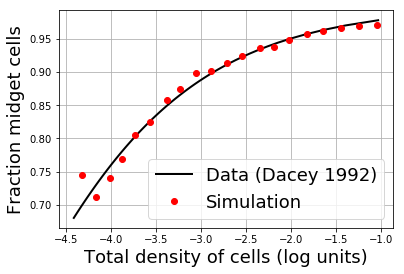

In [19]:
plt.plot(np.log(total_density_data)/np.log(10), ratios_data,'-k', linewidth = 2)
plt.plot(np.log(total_density*0.8)/np.log(10), ratios,'or')
plt.xlabel('Total density of cells (log units)', fontsize = 18)
plt.ylabel('Fraction midget cells', fontsize = 18)
plt.legend(['Data (Dacey 1992)','Simulation'], fontsize = 18)
plt.grid('on')

plt.savefig('eccentricty.eps',bbox_inches = 'tight', pad_inches = .1)

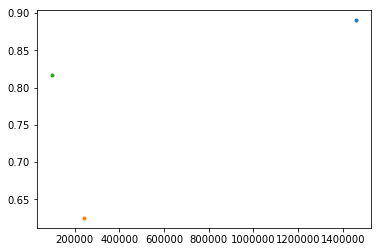

In [16]:
m1 = 1.3*10**6
p1 = 1.6*10**5

m2 = 1.5*10**5
p2 = 9*10**4

m3 = 8*10**4
p3 = 1.8*10**4

plt.plot(m1+p1,m1/(m1+p1),'.')
plt.plot(m2+p2,m2/(m2+p2),'.')
plt.plot(m3+p3,m3/(m3+p3),'.')

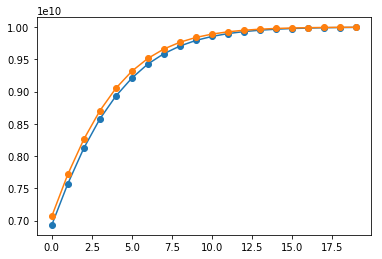

In [17]:
plt.plot(-(np.array(RECS).T/100*np.sum(S)-np.sum(S)),'-o')